In [1]:
from surprise import SVD
from surprise import Reader, Dataset
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


In [2]:
import sys
import logging
import pandas as pd 
import numpy as np
import boto3
import requests  #필수
import base64 #필수
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pymysql #필수
import warnings
import json

#matplotlib 한글 폰트설정
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_name = fm.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
mpl.rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False

pd.set_option('mode.chained_assignment', None)

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points 

# RDS 세팅

In [3]:
#RDS info 세팅
host = 'host'
port=9999
username = 'username'
database='database'
password = 'password'

userhost = 'userhost'
userport=9999
userusername = 'userusername'
userdatabase='userdatabase'
userpassword = 'userpassword'


def connect_RDS(host, port, username, password, database):
    try :
        conn = pymysql.connect(host=host, user=username, passwd=password, db=database, connect_timeout=5)
        cursor = conn.cursor()
    except Exception as e:
        print(e)
        #logging.error("RDS에 연결되지 않았습니다.")
        sys.exit(1)

    return conn, cursor

conn, cursor = connect_RDS(host, port, username, password, database)
userconn, usercursor = connect_RDS(userhost, userport, userusername, userpassword, userdatabase)



In [4]:
def excute_qurey(query,connect = conn):
    try:
        df = pd.read_sql(query,connect)
        return df
    except Exception as e:
        logging.error("Error : {}".format(e))

# 각 루틴에 대한 소요 시간 기준 추천 모델 만들기
### 유저 들이 사용한 루틴 RDS에서 추출, 루틴 선택 하고 사용 내역이 없는 경우 데이터 제외

In [40]:
query ="""
쿼리입력
"""

routine = excute_qurey(query)

## 루틴ID 및 user_id 마스킹

In [41]:
routine_id = pd.DataFrame(routine.name.drop_duplicates()).reset_index(drop=True)
routine_id['routine_id'] = routine_id.index.tolist()
routine_id['routine_id'] = routine_id['routine_id'].apply(str)

In [42]:
user_id = pd.DataFrame(routine.user.drop_duplicates()).reset_index(drop=True)
user_id['user_id'] = user_id.index.tolist()
user_id['user_id'] = user_id['user_id'].apply(str)

In [43]:
routine = pd.merge(routine,routine_id, on = 'name')
routine = pd.merge(routine,user_id, on = 'user')
routine = routine[['user_id','routine_id','time','tags']]
routine[['user_id','routine_id']] = routine[['user_id','routine_id']].applymap(str)

## time은 현재 루틴을 공부하면 소요된 시간을 분 단위로 측정한 데이터
### 하지만 너무 과하게 많은 경우 outlier로 보고 제외하기로 함

Text(0.5, 1.0, 'ln(time) 기준 Boxplot')

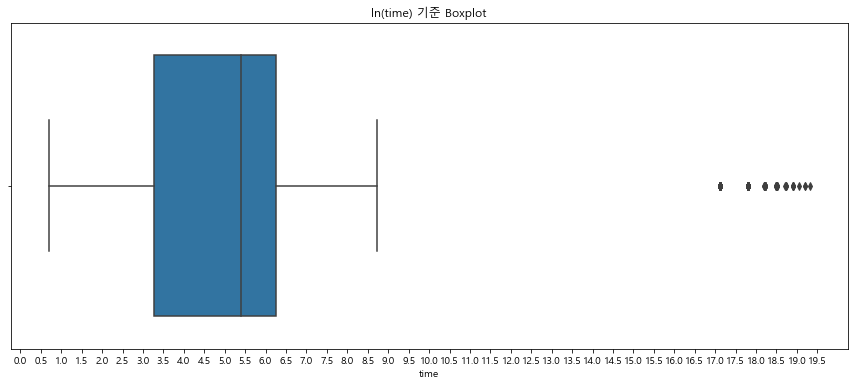

In [10]:
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(np.arange(0,20,0.5))
sns.boxplot(np.log1p(routine.time))
plt.title("ln(time) 기준 Boxplot")

### 위의 boxplot은 ln(time) 기준 이며 8보다 큰 경우가 확인됨,8보다 큰 경우 전체 제외한다.
1개의 루틴은 총 6일 기준이며 하루 8시간 6일씩 공부할 경우 공부시간 2880분, ln(time) 기준 8 정도 된다.   
루틴은 한 과목에 대한 1주일 공부 플랜이며 한 과목을 하루에 8시간 씩 공부하는 경우는 극히 드물다고 판단, 8 이상은 제외함   

In [11]:
routine_filter = routine.loc[np.log1p(routine.time) < 8,['user_id','routine_id','time']]

<AxesSubplot:xlabel='time'>

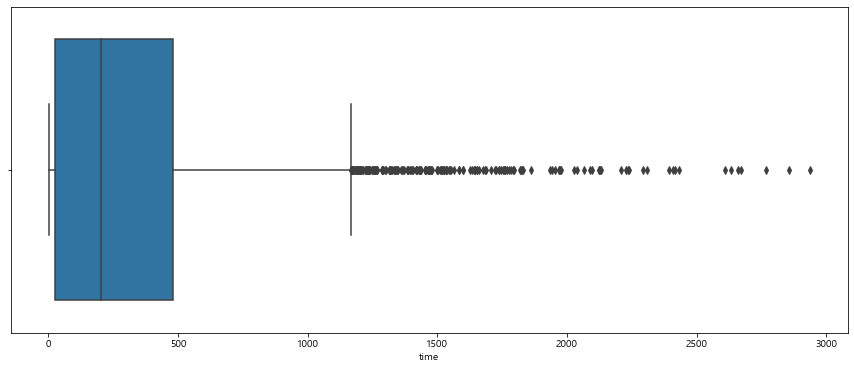

In [12]:
f, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(routine_filter.time)

In [13]:
routine_filter.describe()

,time
count,5794.000
mean,312.412
std,365.376
min,1.000
25%,24.000
50%,203.000
75%,481.000
max,2936.000


## 제외한 이후 루틴 별 공부시간 분포 히스토그램

<AxesSubplot:xlabel='time', ylabel='Count'>

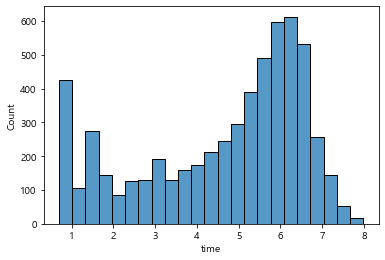

In [14]:
sns.histplot(np.log1p(routine_filter.time))

In [15]:
routine_filter['time'] = np.log1p(routine_filter['time'])

## 훈련데이터 routine_filter 에 대한 설명
|변수명|내용|비고|
|:---:|:---:|:---:|
|user_id|유저ID||
|routine_id|루틴ID||
|time|공부시간|log1p(공부시간min) 결과|


In [16]:
routine_filter

,user_id,routine_id,time
0,0,0,5.940
1,0,9,5.069
2,0,12,5.940
3,0,31,6.184
4,1,0,3.738
...,...,...,...
5994,2907,33,4.796
5995,2908,33,4.454
5996,2909,33,6.284
5997,2910,33,4.290


## scikit-surprise 내 SVD 이용 사용자 기반 잠재 요인 협업 필터링 기반 추천 모델 생성

In [18]:
#데이터 reader 세팅, line_format 내 유저, 항목, 점수에 대한 칼럼 정보를 입력해야한다.
reader = Reader(line_format='user item rating')

data = Dataset.load_from_df(routine_filter, reader=reader)
#train-test 데이터 분할
trainset, testset  = train_test_split(data, test_size=.25, random_state=0)

In [19]:
from surprise.model_selection import GridSearchCV

#하이퍼 파라미터 튜닝
param_grid = {'n_epochs': np.arange(10,100,5), 'n_factors': np.arange(10,100,10)}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mse'], cv=3)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.790650828699975
{'n_epochs': 80, 'n_factors': 10}


In [20]:
#n_epochs는 크기를 늘려도 큰 변화가 없어 50으로 고정
algo = SVD(n_epochs=50, n_factors=20, random_state=0)
algo.fit(trainset)

algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 1.8087


1.8087441267037323

## 하이퍼 파라미터 튜닝 완료 이후 전체 데이터를 이용하여 모델 Train 시킨다.
위에서는 train, test 데이터를 train_test_split 함수를 통해 나눴지만   
전체 데이터를 train으로 사용하기 위해서는 DatasetAutoFolds 함수를 import 해여 사용해야한다.


In [21]:
data_folds = DatasetAutoFolds(df=routine_filter, reader=reader)
trainset = data_folds.build_full_trainset()
algo.fit(trainset)


In [22]:
def get_never_took_surprise(routine_df,userId):
    global routine_id
    routine_took = routine_df[routine_df['user_id'] == str(userId)]
    took = routine_took['routine_id'].apply(str)
    never_took = routine_id[~routine_id.routine_id.isin(took)]
    print('참여한 루틴 수:', len(took),'참여한 루틴 평균 공분 시간(분):', round(np.exp(np.mean(routine_took.time)),1) , '추천 대상 루틴 수:', len(never_took), '전체 루틴 수:', len(routine_id))

    return never_took['routine_id']


In [23]:
def recomm_routine_by_surprise(algo, userId, never_took, top_n=10):
    global routine_id
    predictions = [algo.predict(str(userId), str(routine_id)) for routine_id in never_took]

    def sortkey_est(pred):
        return pred.est

    predictions.sort(key=sortkey_est, reverse=True)
    top_predictions = predictions[:top_n]

    top_routine_ids = [str(pred.iid) for pred in top_predictions]
    top_routine_rating = [pred.est for pred in top_predictions]
    top_routine_titles = routine_id[routine_id.routine_id.isin(top_routine_ids)]['name']
    top_routine_pred = [(id, title, rating) for id, title, rating in zip(top_routine_ids, top_routine_titles, top_routine_rating)]
    return top_routine_pred
    
    
never_took = get_never_took_surprise(routine_filter, 52)
top_routine_preds = recomm_routine_by_surprise(algo, 52, never_took, top_n=10)

print('### Recommendation Top 10 #######')
for top_routine in top_routine_preds:
    print(top_routine[1], " 루틴 공부 예상 시간(분):", np.exp(top_routine[2]))


참여한 루틴 수: 4 참여한 루틴 평균 공분 시간(분): 580.4 추천 대상 루틴 수: 30 전체 루틴 수: 34
### Recommendation Top 10 #######
2022 AOK 13주차 승리하기 (워크북 X)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 12주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 8주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 5주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 16주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 9주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 4주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 7주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 15주차 승리하기 (워크북 포함)  루틴 공부 예상 시간(분): 148.4131591025766
2022 AOK 12주차 승리하기 (워크북 X)  루틴 공부 예상 시간(분): 148.4131591025766


## 코싸인 유사도 기준 아이템 기반 잠재 요인 협업 필터링 기반 추천 모델 생성
이전에는 사용자들의 이용 현황을 기준으로 모델을 생성한 뒤, 사용자 A가 루틴 X를 사용했을 때 예상되는 공부시간을 예측했다.    
아래는 루틴 X 기준으로 다른 루틴과 코싸인 유사도를 측정하는 모델을 생성했다.

In [24]:
#루틴 기준 유저 별 공부 시간 피버팅
routine_pivot = routine_filter.pivot_table('time',index='routine_id',columns='user_id').fillna(0)


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
#참조  - https://lsjsj92.tistory.com/568
#피버팅 된 DF를 이용하여 코사인 유사도 계산
item_based_collabor = cosine_similarity(routine_pivot)

In [26]:
item_based_collabor_df = pd.DataFrame(item_based_collabor)

In [27]:
def get_item_based_result(df,routineId):
    global routine_id
    tmp = df[int(routineId)].sort_values(ascending=False).reset_index()
    tmp.columns = ['routine_id','similarity']
    tmp = tmp.query("routine_id != {}".format(routineId))
    tmp['routine_id'] = tmp['routine_id'].apply(str)
    tmp = pd.merge(tmp,routine_id,on = 'routine_id')
    print("")
    return tmp[['name','similarity']]

#위에서 구한 코싸인 유사도 행렬에서 routine_id을 입력하면 유사도 결과가 나오도록 함수 생성
result = get_item_based_result(item_based_collabor_df,2)
result.head(10)

,name,similarity
0,2022 AOK 10주차 승리하기 (워크북 포함),0.727
1,2022 AOK 9주차 승리하기 (워크북 X),0.670
2,2022 AOK 15주차 승리하기 (워크북 포함),0.616
3,2022 AOK 2주차 승리하기 (워크북 포함),0.551
4,2022 AOK 15주차 승리하기 (워크북 X),0.510
5,2022 AOK 4주차 승리하기 (워크북 X),0.456
6,2022 AOK 7주차 승리하기 (워크북 X),0.413
7,2022 AOK 3주차 승리하기 (워크북 포함),0.377
8,2022 AOK 8주차 승리하기 (워크북 포함),0.301
9,2022 AOK 5주차 승리하기 (워크북 X),0.249


# 루틴 내 태그 기준 코싸인 유사도 구하기
위의 두 가지 추천 모델은 신규 유저 및 신규 루틴이 추가된 경우,   
사용정보가 존재하지 않기 때문에 추천이 되지 않던가 혹은 유저 입장에서 이해하기 힘든 추천 루틴이 나올 수 있다.   
고민한 결과 도모버스 루틴에서는 각 루틴에 대한 키워드를 담은 태그 정보를 이용한다면 신규 루틴이 생성되어도 해당 루틴 내 태그와 유사도가 높은 태그를 가진 루틴을 리턴한다면 cold start에 대한 대처가 제한적이나마 가능할 것으로 본다.
   
해당 데이터를 이용해서 코싸인 유사도를 구하여 태그 추천 모델을 만들어 보았다.

In [46]:
routine_filter2 = routine.loc[np.log1p(routine.time) < 8,['user_id','routine_id','time','tags']]

In [47]:
routine_filter2['time'] = np.log1p(routine_filter2['time'])

In [48]:
routine_filter2.tags = routine_filter2.tags.apply(lambda x: eval(x))

In [60]:
routine_filter2 = routine_filter2.explode('tags')

In [59]:
routine_filter2.head()

,user_id,routine_id,time,tags
0,0,0,4.078,"[김승리, All of KICE, 1주차]"
1,1,0,4.615,"[김승리, All of KICE, 1주차]"
2,2,0,0.693,"[김승리, All of KICE, 1주차]"
3,3,0,4.673,"[김승리, All of KICE, 1주차]"
4,3,12,4.025,"[김승리, All of KICE, 4주차]"


In [79]:
routine_filter2_pivot = routine_filter2.pivot_table('time',index='tags',columns='routine_id',aggfunc=np.mean).fillna(0)

In [121]:
routine_filter2_pivot

routine_id,0,1,10,11,12,13,14,15,16,17,...,3,30,31,32,33,4,6,7,8,9
tags,,,,,,,,,,,,,,,,,,,,,
10주차,0.000,0.000,0.000,0.000,0.000,0.000,4.512,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.330,0.000
11주차,0.000,4.331,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
12주차,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,5.488,0.000,0.000,0.000
13주차,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14주차,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.740,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
15주차,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.638,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16주차,0.000,0.000,5.205,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1주차,4.029,0.000,0.000,0.000,0.000,3.534,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2주차,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,4.965,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [83]:
tag_based_collabor = cosine_similarity(routine_filter2_pivot)

In [93]:
tags_id = routine_filter2_pivot.reset_index()['tags'].reset_index()
tags_id.columns = ['tags_id','name']

In [99]:
tags_id.dtypes

tags_id     int64
name       object
dtype: object

In [84]:
tag_based_collabor_df = pd.DataFrame(tag_based_collabor)

In [105]:
tmp = tag_based_collabor_df[int(2)].sort_values(ascending=False).reset_index()
tmp.columns = ['tags_id','similarity']
tmp = tmp.query("tags_id != {}".format(2))
tmp['tags_id'] = tmp['tags_id'].apply(str)
    

In [113]:
def get_tag_based_result(df,tagsId):
    global tags_id
    tmp = df[int(tagsId)].sort_values(ascending=False).reset_index()
    tmp.columns = ['tags_id','similarity']
    tmp = tmp.query("tags_id != {}".format(tagsId))
    tmp['tags_id'] = tmp['tags_id'].apply(int)
    tmp = pd.merge(tmp,tags_id,on = 'tags_id')
    print("")
    return tmp[['name','similarity']]


result_tag = get_tag_based_result(tag_based_collabor_df,18)
result_tag.head(10)

,name,similarity
0,1주차,0.538
1,김승리,0.130
2,4주차,0.000
3,All of KICE,0.000
4,9주차,0.000
5,8주차,0.000
6,7주차,0.000
7,6주차,0.000
8,5주차,0.000
9,10주차,0.000


<AxesSubplot:>

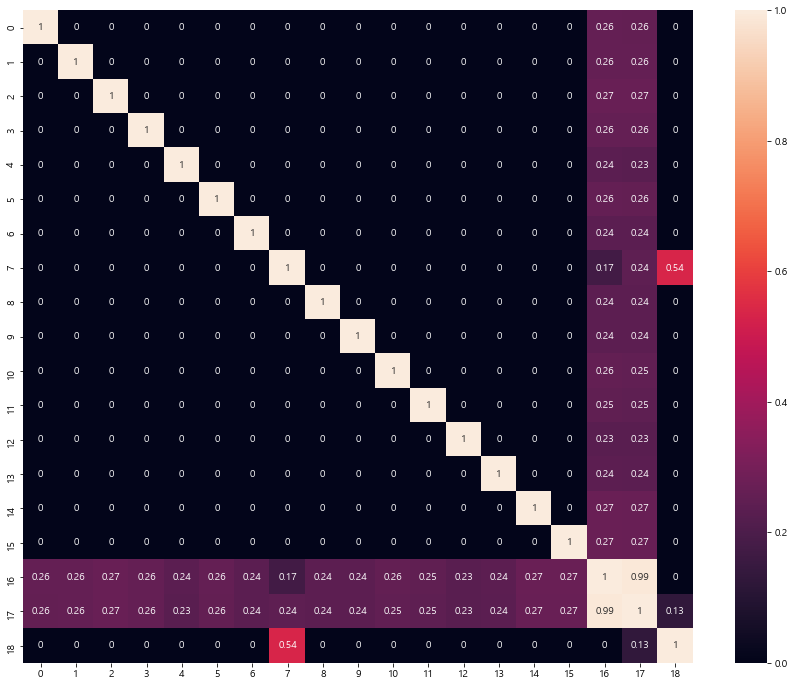

In [127]:
import seaborn as sns
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(tag_based_collabor_df,annot=True)

In [126]:
tags_id

,tags_id,name
0,0,10주차
1,1,11주차
2,2,12주차
3,3,13주차
4,4,14주차
5,5,15주차
6,6,16주차
7,7,1주차
8,8,2주차
9,9,3주차


### 시도한 결과 김승리, All of Kice를 제외한 태그는 의미가 없었으며, 유의미한 태그가 너무 적어 검증 불가능
향후 루틴 생성 시 태그를 설정할 때 XX주차 단어는 제외하는 것이 좋다고 판단되며 문학, 비문학, 고전문학 등 해당 루틴에서 주로 공부했던 내용에 대한 태그를 추가하여 유의미한 태그를 생성한 다음 다시 검증에 나서는 것이 더 좋을 것 같다고 판단됨.

## 향후에는 공부시간 외에도 모의고사 성적 및 성적향상도 등을 고려한 모델생성도 고려
